In [1]:
import logging
import os
import random
from collections import Counter
from importlib import reload


import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

/home/estorrs/miniconda3/envs/pollock/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
pollock.models.model.set_training_devices(['/device:XLA_GPU:0'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:XLA_GPU:0',)


2020-02-11 12:57:03,623 Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:XLA_GPU:0',)


In [ ]:
# from importlib import reload
# reload(pollock)
# reload(pollock.models.model)

In [5]:
from tensorflow.python.client import device_lib
import tensorflow as tf
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13004097704326393223,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13759611038398174191
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5752826673673924153
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8302899375032254623
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4952259967847605326
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5679738596861174500
 physical_device_desc: "device: XLA_GPU device"]

In [ ]:
tf.config.list_physical_devices('XLA_GPU')

In [ ]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy(
    devices=["/device:XLA_GPU:0"])

## load in expression table and labels

In [6]:
expression_fp = '/home/estorrs/data/single_cell_classification/Intra-dataset/Zheng 68K/Filtered_68K_PBMC_data.csv'
label_fp = '/home/estorrs/data/single_cell_classification/Intra-dataset/Zheng 68K/Labels.csv'


In [7]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=',')
expression_df

CPU times: user 6min 4s, sys: 17 s, total: 6min 21s
Wall time: 6min 19s


,Unnamed: 0,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
0,AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65938,TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65939,TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65940,TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65941,TTTGCATGCTGCAA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
expression_df = expression_df.set_index('Unnamed: 0')
expression_df

,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,SAMD11,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
label_df = pd.read_csv(
    label_fp,
    sep=','
    )
label_df

,x
0,CD8+ Cytotoxic T
1,CD8+/CD45RA+ Naive Cytotoxic
2,CD4+/CD45RO+ Memory
3,CD19+ B
4,CD4+/CD25 T Reg
...,...
65938,CD8+/CD45RA+ Naive Cytotoxic
65939,CD8+ Cytotoxic T
65940,CD8+/CD45RA+ Naive Cytotoxic
65941,CD8+ Cytotoxic T


In [10]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

Transforming to str index.


AnnData object with n_obs × n_vars = 65943 × 20387 
    obs: 'x'

In [11]:
Counter(adata.obs['x']).most_common()

[('CD8+ Cytotoxic T', 20307),
 ('CD8+/CD45RA+ Naive Cytotoxic', 16361),
 ('CD56+ NK', 8522),
 ('CD4+/CD25 T Reg', 6116),
 ('CD19+ B', 5579),
 ('CD4+/CD45RO+ Memory', 3031),
 ('Dendritic', 1946),
 ('CD14+ Monocyte', 1944),
 ('CD4+/CD45RA+/CD25- Naive T', 1857),
 ('CD34+', 188),
 ('CD4+ T Helper2', 92)]

In [12]:
# ## ranodom subset for testing
# idxs = np.asarray(random.sample(range(adata.shape[0]), 10000))
# adata = adata[idxs, :]
# adata

In [13]:
## filter smartly
cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs['x']):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > 100:
        return random.sample(ls, 100)
    return ls

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
adata = adata[idxs]

In [14]:
adata.obs

,x
Unnamed: 0,
CGCAGGTGTCTATC-7,CD8+ Cytotoxic T
CAAGTTCTAGTCTG-4,CD8+ Cytotoxic T
CCGACACTGTACGT-3,CD8+ Cytotoxic T
CACTAGGAAGTCGT-4,CD8+ Cytotoxic T
GCAGATACCGTGAT-4,CD8+ Cytotoxic T
...,...
GTTTAAGATCGCCT-3,CD14+ Monocyte
CGGACTCTCCGTTC-5,CD14+ Monocyte
TAATGTGATCTCGC-2,CD14+ Monocyte


In [15]:
def make_safe_filename(s):
    def safe_char(c):
        if c.isalnum():
            return c
        else:
            return "_"
    return "".join(safe_char(c) for c in s).rstrip("_")

adata.obs['x'] = [make_safe_filename(x) for x in adata.obs['x']]
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 1092 × 20387 
    obs: 'x'

In [16]:
Counter(adata.obs['x']).most_common()

[('CD8__Cytotoxic_T', 100),
 ('CD8__CD45RA__Naive_Cytotoxic', 100),
 ('CD4__CD45RO__Memory', 100),
 ('CD19__B', 100),
 ('CD4__CD25_T_Reg', 100),
 ('CD56__NK', 100),
 ('CD4__CD45RA__CD25__Naive_T', 100),
 ('CD34', 100),
 ('Dendritic', 100),
 ('CD14__Monocyte', 100),
 ('CD4__T_Helper2', 92)]

In [17]:
adata.var

""
AL627309.1
AP006222.2
RP11-206L10.3
RP11-206L10.2
RP11-206L10.9
...
AC011841.1
AL354822.1
KIR2DL2
PNRC2.1


In [ ]:
# sc.tl.rank_genes_groups(adata, 'Class', method='t-test', n_genes=100)

## train pollock model

In [18]:
%%time

pollock_dataset = pollock.models.model.PollockDataset(adata, cell_type_key='x', dataset_type='training',
                                image_root_dir='/home/estorrs/pollock/models/scratch/test_zheng',
                                n_per_cell_type=100, max_val_per_cell_type=500)

2020-02-11 16:06:54,632 creating image templates
... storing 'x' as categorical
2020-02-11 16:06:56,379 writing training images
2020-02-11 16:06:56,646 writing images
2020-02-11 16:06:56,648 0 cell images written
2020-02-11 16:07:21,464 1000 cell images written
2020-02-11 16:07:23,726 done writing images
2020-02-11 16:07:23,780 creating training dataset
2020-02-11 16:07:24,405 creating validation dataset


CPU times: user 29.3 s, sys: 684 ms, total: 29.9 s
Wall time: 29.9 s


In [19]:
x,y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 11]))

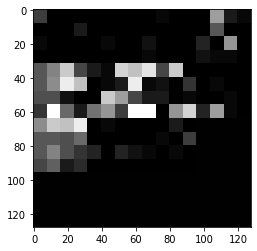

In [20]:
cell_id = adata.obs.index[0]
img = pollock_dataset.get_cell_image(cell_id)

In [21]:
pollock_dataset.cell_types

['CD14__Monocyte',
 'CD19__B',
 'CD34',
 'CD4__CD25_T_Reg',
 'CD4__CD45RA__CD25__Naive_T',
 'CD4__CD45RO__Memory',
 'CD4__T_Helper2',
 'CD56__NK',
 'CD8__CD45RA__Naive_Cytotoxic',
 'CD8__Cytotoxic_T',
 'Dendritic']

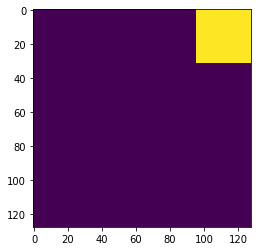

In [22]:
plt.imshow(pollock_dataset.cell_type_template=='CD4__CD25_T_Reg')

In [23]:
model = PollockModel(pollock_dataset.cell_types, model='resnet50')

In [24]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 4, 4, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 24,619,531
Trainable params: 24,574,091
Non-trainable params: 45,440
_______________________________________

In [ ]:
# base_model = tf.keras.applications.ResNet50V2(input_shape=(128, 128, 3),
#     include_top=False)
# mymodel = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(.5),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(len(model.class_names), activation='softmax')
#     ])
# mymodel.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy'])

# model.model = mymodel

In [ ]:
model.model.summary()

In [25]:
# with tf.device('/device:XLA_GPU:0'):

model.fit(pollock_dataset)

Train for 18 steps, validate for 4 steps
Epoch 1/10
 7/18 [==========>...................] - ETA: 23s - loss: 2.2083 - accuracy: 0.2604WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2020-02-11 16:07:51,925 Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [ ]:
model.save(pollock_dataset, '/home/estorrs/pollock/models/abm_3class')

In [ ]:
%%time
prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/abm_3class',
        image_root_dir = '/home/estorrs/pollock/models/scratch/test_amb_prediction')

In [ ]:
probs = model.predict(prediction_dataset)
probs.shape

In [ ]:
predictions = np.argmax(probs, axis=1).flatten()
predicted_labels = [prediction_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

In [ ]:
cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in adata[prediction_dataset.cell_ids, :].obs['Class']]
len(groundtruth), groundtruth[:5]

In [ ]:
predictions[:20], groundtruth[:20]

In [ ]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, prediction_dataset.cell_types)

In [ ]:
embedding = pollock_analysis.umap_final_layer(prediction_dataset.prediction_ds, model.model)
embedding.shape

In [ ]:
ordered_adata = adata[prediction_dataset.cell_ids, :]
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(ordered_adata, color=['predicted_cell_type', 'Class'])